# **Phase 2 Enhanced Question Generation**

**Gil Levy** and **Liad Levi Raz** (3rd notebook)

The Enhanced model with the enhanced dataset
---


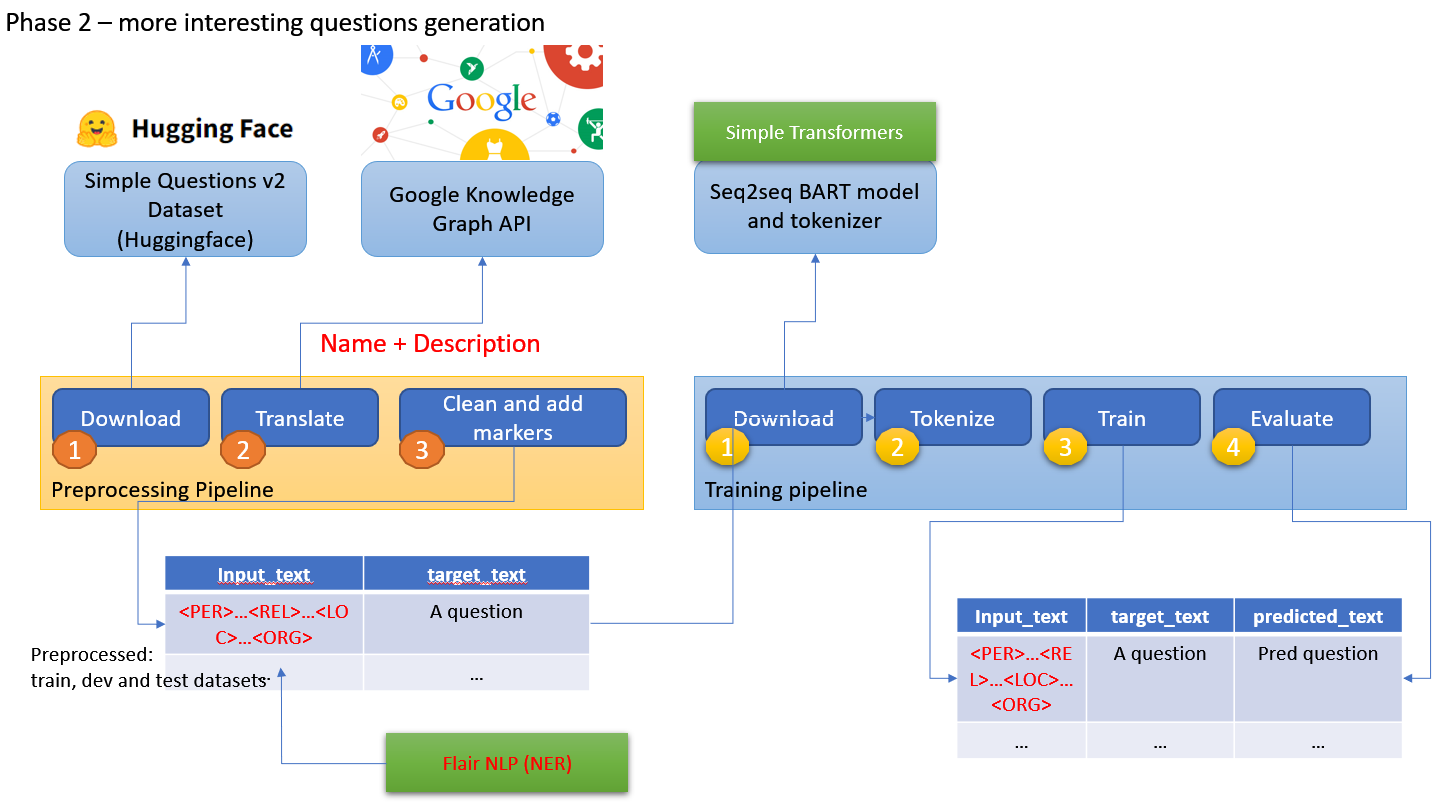

## Installing libraries


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH='/content/drive/MyDrive/2022/S2/3523_Natural_Language_Processing/notebooks/final_proj/'

SEED=42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#cleaning older cache
# !rm -rf cache_dir
# !rm -rf outputs/checkpoint*
# !rm -rf runs
# !rm -rf outputs/

In [ ]:
!pip install -q simpletransformers pip transformers

In [ ]:
import os
import gc
import torch
import copy
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# import sklearn
# from sklearn.metrics import confusion_matrix ,matthews_corrcoef,accuracy_score
# from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu

#NLP related
from transformers import BartTokenizer
from simpletransformers.seq2seq import Seq2SeqModel, Seq2SeqArgs

#Pytorch
import torch
import torch.nn as nn

pd.set_option("max_colwidth", 1000)
warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = 'False'

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Loading SQ2 Data

14k randonly selected training instances
+ +1k for dev
+ +2k for test

In [ ]:
!cp -rn {DRIVE_PATH}/data . 

In [ ]:
train_seq2seq_df = pd.read_csv('data/p2/p2_train_seq2seq_df.csv',index_col=0)
val_seq2seq_df = pd.read_csv('data/p2/p2_val_seq2seq_df.csv',index_col=0)
test_seq2seq_df = pd .read_csv('data/p2/p2_test_seq2seq_df.csv',index_col=0)


In [ ]:
train_seq2seq_df.head(5)

,input_text,target_text
0,<MISC>The Debt</MISC> is a two-part <MISC>British</MISC> television crime drama film <rel> /film/film/country <rel>The <LOC>United Kingdom of Great Britain</LOC> and <LOC>Northern Ireland</LOC>,what country was the film the debt from
1,Warner Bros. Pictures is an <MISC>American</MISC> film production and distribution company of the Warner Bros. Pictures Group division of Warner Bros. The studio is the flagship producer of live-action feature films within the Warner Bros. Pictures Group unit <rel> /film/production_company/films <rel><MISC>Saving Shiloh</MISC> is a 2006 <MISC>American</MISC> family drama film directed by <PER>Sandy Tung</PER>,what movie is produced by warner bros.
2,<LOC>Columbus</LOC> is the state capital and the most populous city in the <LOC>U.S.</LOC> state of <LOC>Ohio</LOC>. With a population of 905 <rel> /travel/travel_destination/tourist_attractions <rel><LOC>Nationwide Arena</LOC> is a multipurpose arena in <LOC>Columbus</LOC>,what's there to see in columbus
3,<LOC>Detroit</LOC> is the largest city in the <LOC>U.S.</LOC> state of <LOC>Michigan</LOC>. It is also the largest <LOC>U.S.</LOC> city on the <LOC>United States</LOC>–<LOC>Canada</LOC> border <rel> /location/location/people_born_here <rel><PER>James Moss</PER>,who is a musician born in detroit
4,<ORG>RYNA</ORG> were a rock band from <LOC>Manchester</LOC> <rel> /music/artist/origin <rel><LOC>Manchester</LOC> is a city in Greater <LOC>Manchester</LOC>,Which city did the artist ryna originate in


In [ ]:
def reset_df(df):
  df = df.reset_index()
  df.drop(['index'],axis=1,inplace=True)
  return df
train_seq2seq_df = reset_df(train_seq2seq_df)
val_seq2seq_df = reset_df(val_seq2seq_df)
test_seq2seq_df = reset_df(test_seq2seq_df)

In [ ]:
train_seq2seq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9719 entries, 0 to 9718
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   input_text   9719 non-null   object
 1   target_text  9719 non-null   object
dtypes: object(2)
memory usage: 152.0+ KB


In [ ]:
initial_num_records = len(train_seq2seq_df)

In [ ]:
train_seq2seq_df.shape,val_seq2seq_df.shape, test_seq2seq_df.shape

((9719, 2), (5192, 2), (10478, 2))

Extract input and output max lengths - in tokens
This is one of the model parameters which helps limit the generated text length and also shorter sequences are trained faster.

In [ ]:
SREL= '<rel>'
EREL= '</rel>'
all_tags = ['PER','LOC','ORG','MISC']
ltags = ['<'+tag+'>' for tag in list(all_tags)]
ltags.extend(['</'+tag+'>' for tag in list(all_tags)])

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
#TODO add the right tokens i added in the add_tags
num_added_toks = tokenizer.add_tokens([SREL,EREL])
# num_added_toks+=tokenizer.add_tokens(tagger.label_dictionary.get_items())
num_added_toks+=tokenizer.add_tokens(ltags)

print("Added", num_added_toks, "tokens, Vocab size:",tokenizer.vocab_size)


Added 10 tokens, Vocab size: 50265


In [ ]:
# find the maximum snetence length after tokenizer
# dummy_tok = BartTokenizer.from_pretrained('facebook/bart-large')
def find_max_lengths(df,percent,dummy_tok):
  max_sent_length = 0
  max_sent_length_list = []

  max_target_length = 0
  max_target_length_list = []
  for sent in tqdm(df.iterrows(),total=len(df)):
      input_len = len(dummy_tok(sent[1]['input_text'])['input_ids'])
      target_len = len(dummy_tok(sent[1]['target_text'])['input_ids'])
      max_sent_length_list.append(input_len)
      max_target_length_list.append(target_len)

  max_sent_length = int(np.percentile(max_sent_length_list,percent))+1
  max_target_length = int(np.percentile(max_target_length_list,percent))+1
  print('{}th percentile of input are in length:{}'.format(percent,max_sent_length))
  print('{}th percentile of target are in length:{}'.format(percent,max_target_length))
  return max_sent_length,max_target_length

a,b = find_max_lengths(train_seq2seq_df,99.5,tokenizer)
print ("Train Max input length after tokenization {} , max target len {}: ".format(a,b))


print (" Max input len:{}, max target len:{} after tokenization ".format(a,b))
max_len_for_seq=a # use only train with some buffer of 5
max_gen_len=b # use only train with some buffer of 5

  0%|          | 0/9719 [00:00<?, ?it/s]

99.5th percentile of input are in length:138
99.5th percentile of target are in length:22
Train Max input length after tokenization 138 , max target len 22: 
 Max input len:138, max target len:22 after tokenization 


In [ ]:
def clear_cache():
  gc.collect()
  torch.cuda.empty_cache()

# Basic Model - SimpleTransformers BART

In [ ]:
#hyperparams
# after very few epochs the model results are nice - but the loss continues to improve for about 6 to 10 epochs
n_epochs=15
#a small batch size for the colab GPU to work
BS=12
# a small learning rate, higher rates results were less good
LR=0.00001

#BART
MODEL_NAME="bart"
ENC_DEC_TYPE="facebook/bart-large" #=60 nice looking questions !

# Other attempts:
# MODEL_NAME="mbart" # is also quite good
# ENC_DEC_TYPE="facebook/bart-large-xsum"
# ENC_DEC_TYPE="facebook/bart-large-cnn"
# ENC_DEC_TYPE="facebook/mbart-large-50-one-to-many-mmt"=57, nice looking questions !
# ENC_DEC_TYPE="facebook/mbart-large-cc25"=52, 
# ENC_DEC_TYPE="facebook/mbart-large-50" #=56,

This is based on the example code from SimpleTransformers:
https://simpletransformers.ai/docs/seq2seq-specifics/



In [ ]:
import logging

import pandas as pd
from simpletransformers.seq2seq import (
    Seq2SeqModel,
    Seq2SeqArgs,
)

logging.basicConfig(level=logging.ERROR)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.ERROR)

model_args = Seq2SeqArgs()
model_args.num_train_epochs = n_epochs
model_args.overwrite_output_dir = True
model_args.no_save = False
model_args.evaluate_generated_text = True
model_args.evaluate_during_training = True
model_args.evaluate_during_training_verbose = True
model_args.train_batch_size=BS
model_args.learning_rate=LR
model_args.fp16=True
model_args.save_eval_checkpoints	=True #	Save a model checkpoint for every evaluation performed.
model_args.save_model_every_epoch = False #Save a model at the end of every epoch
#input
model_args.max_seq_length = max_len_for_seq
#target
model_args.max_length = max_gen_len
# model_args.min_length = 4
model_args.early_stopping = True
model_args.use_early_stopping = True
model_args.src_lang =  'en_XX'
model_args.tgt_lang =  'en_XX'

# Initialize model
model = Seq2SeqModel(
    encoder_decoder_type=MODEL_NAME, 
    encoder_decoder_name=ENC_DEC_TYPE,
    args=model_args,
    use_cuda=torch.cuda.is_available(),
)

model.model.resize_token_embeddings(len(tokenizer))

def bleu_scr(labels, preds):
    print('5 T:',labels[:5])
    print('5 P:',preds[:5])
    bl_arr=[]
    for label, pred in zip(labels, preds): 
      bl_arr.append(sentence_bleu([pred],label))
    avg_bleu = np.mean(bl_arr)
    print('avg_bleu:{:.3f}'.format(avg_bleu))
    return avg_bleu



Setting the decoder start token as the Encoder's "end of sentence" token is very important - before setting this - we got bad predictions.

In [ ]:
# for p in model.model.named_parameters():
#   if(p[1].requires_grad==True):
#     print(p[0],'\t',p[1].requires_grad)
# The decoder start token is the end sentence of the encoder !!!
model.decoder_tokenizer.decode(model.config.decoder_start_token_id)

'</s>'

In [ ]:
%%time

# Train or Inference mode
TRAINED_MODEL='p2_bart_14k_model_v1.zip'
!cp -nf {DRIVE_PATH}/last_model/{TRAINED_MODEL} .
INFERENCE_MODE = os.path.isfile(TRAINED_MODEL)
if(INFERENCE_MODE):
  print('Inference mode, loading best model...')
  !unzip -q -n {TRAINED_MODEL}
  model = Seq2SeqModel(
      encoder_decoder_type=MODEL_NAME, 
      encoder_decoder_name="outputs/best_model",
      args=model_args,
      use_cuda=torch.cuda.is_available(),
  )
  print('Best model loaded.')
else:
  print('Training mode')


Inference mode, loading best model...
Best model loaded.
CPU times: user 3.59 s, sys: 2.18 s, total: 5.77 s
Wall time: 9.36 s


## Train

In [ ]:
%%time

if(not INFERENCE_MODE):
  clear_cache()

  start = datetime.now()

  # Train the model
  steps,details = model.train_model(
      train_seq2seq_df, eval_data=val_seq2seq_df, bleu=bleu_scr
  )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [ ]:
def loss_graph(loss_train_arr , loss_dev_arr , bleu_train_arr , bleu_dev_arr , test_name = 'Dev'):
    fig, ax = plt.subplots(1, 2,figsize=(14, 5))

    ax[0].set_title('Loss vs Epoch')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    # ax[0].set_yscale('log')
    ax[0].plot(loss_train_arr,label="Train loss")
    ax[0].plot(loss_dev_arr,  label="{} loss".format(test_name))
    ax[0].legend()
        
    ax[1].set_title('bleu vs Epoch')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('bleu')
    # ax[0].set_yscale('log')
    ax[1].plot(bleu_train_arr,  label="Train bleu")
    ax[1].plot(bleu_dev_arr,  label="{} bleu".format(test_name))
    ax[1].legend()  

if(not INFERENCE_MODE):
  loss_graph(details['train_loss'],details['eval_loss'],[],details['bleu'])

## Evaluate

In [ ]:
# Evaluate the model on "train" expecting good results
results = model.eval_model(train_seq2seq_df[:1000], bleu=bleu_scr)
results

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/125 [00:00<?, ?it/s]

5 T: ['what country was the film the debt from', 'what movie is produced by warner bros.', "what's there to see in columbus", 'who is a musician born in detroit', 'Which city did the artist ryna originate in']
5 P: ['what country is the debt from', 'what is a film produced by warner bros.', 'what is a tourist attraction in columbus', 'who was born in detroit', 'where did ryna originate from']
avg_bleu:0.645


{'eval_loss': 0.07334463632106782, 'bleu': 0.645085513130997}

In [ ]:
# Evaluate the model on test
results = model.eval_model(test_seq2seq_df,bleu=bleu_scr)
results

  0%|          | 0/10478 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1310 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/1310 [00:00<?, ?it/s]

5 T: ['Which genre of album is harder.....faster?', 'what format is fearless', 'what film is by the writer phil hay?', 'Which equestrian was born in dublin?', 'What is a tv action show?']
5 P: ['what kind of music is harder... faster', 'what kind of release was fearless', 'what film did phil hay write?', 'who was born in dublin', 'what is an action fiction tv program']
avg_bleu:0.615


{'eval_loss': 0.10018098778340198, 'bleu': 0.614734130511816}

In [ ]:
print('MODEL Generation CONFIG')
print('model.training=',model.model.training)
# print('decoder_start_token_id=',model.config.decoder.pad_token_id)
print('num_beams=',model.config.num_beams,)
print('max_length=',model.config.max_length,)
print('length_penalty=',model.config.length_penalty,)
print('early_stopping=',model.config.early_stopping,)
print('repetition_penalty=',model.config.repetition_penalty,)
print('do_sample=',model.config.do_sample,)
print('top_k=',model.config.top_k,)
print('top_p=',model.config.top_p,)
print('num_return_sequences=',model.config.num_return_sequences)

MODEL Generation CONFIG
model.training= False
num_beams= 4
max_length= 20
length_penalty= 1.0
early_stopping= True
repetition_penalty= 1.0
do_sample= False
top_k= 50
top_p= 1.0
num_return_sequences= 1


## Predict

Predicting on some of the test samples:

In [ ]:
inp_samples = [str(inp) for inp in test_seq2seq_df['input_text'][1:5].values]
tgt_samples = [str(tgt) for tgt in test_seq2seq_df['target_text'][1:5].values]

prds = model.predict(inp_samples)
bleus = []
for p,t in zip(prds,tgt_samples):
  print('True: ',t.strip().capitalize())
  print('Pred: ',p.strip().capitalize())
  b = sentence_bleu([p],t)
  print('BLEU:{:.2f}'.format(b))
  print('---------------------------')


Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

True:  What format is fearless
Pred:  What kind of release was fearless
BLEU:0.39
---------------------------
True:  What film is by the writer phil hay?
Pred:  What film did phil hay write?
BLEU:0.60
---------------------------
True:  Which equestrian was born in dublin?
Pred:  Who was born in dublin
BLEU:0.51
---------------------------
True:  What is a tv action show?
Pred:  What is an action fiction tv program
BLEU:0.42
---------------------------


### Predicting on totally new texts

In [ ]:
#TODO MOVE TO IMPORTS

!pip install -q flair

from pprint import pprint
from flair.data import Sentence
from flair.models import SequenceTagger

# load tagger
tagger = SequenceTagger.load("flair/ner-english-large")

     |████████████████████████████████| 401 kB 9.9 MB/s 
     |████████████████████████████████| 19.7 MB 1.3 MB/s 
     |████████████████████████████████| 1.2 MB 63.3 MB/s 
     |████████████████████████████████| 981 kB 67.2 MB/s 
     |████████████████████████████████| 46 kB 4.4 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 788 kB 59.4 MB/s 
     |████████████████████████████████| 1.6 MB 53.4 MB/s 
     |████████████████████████████████| 199 kB 76.8 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.7 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.15.0 which is incompatible.
google-colab 1.0.0

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

2022-07-03 07:42:23,410 loading file /root/.flair/models/ner-english-large/07301f59bb8cb113803be316267f06ddf9243cdbba92a4c8067ef92442d2c574.554244d3476d97501a766a98078421817b14654496b86f2f7bd139dc502a4f29


Downloading:   0%|          | 0.00/616 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

2022-07-03 07:42:42,465 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [ ]:
def add_tags(text):
  sent = Sentence(text)
  tagger.predict(sent)
  texts = {}

  for entity in sent.get_spans('ner'):
      txt_with_markers = str('<' + entity.tag + '>'+entity.text+'</' + entity.tag + '>').strip()
      texts[entity.text]= txt_with_markers

  for text2replace in texts:
    text = text.replace(text2replace,texts[text2replace])

  return text

In [ ]:
# model.config.num_return_sequences =40
# Use the model for prediction of some unseen facts
texts = [
              add_tags("Tel Aviv <rel>/location/location/contains</rel> Yarkon Stream"), #different names of entities but known relation
              add_tags("Amir is the <rel>lecturer</rel> of the Natural Language Processing course in Reichman university"), #new relations
              #with our "NER"
              "<se> Indian people <rel> /people/ethnicity/people <oe>Vinod Khanna	",
              # "<se> Painting <rel> /visual_art/visual_art_form/artists <oe>Manolo Valdés",
              # "<se> Boxing <rel> /martial_arts/martial_art/well_known_practitioner <oe> Philip Holiday",
              # "<se> Emperor Magus Caligula <rel> /people/person/nationality <oe>Sweden", 
              #with Flair NERs
              add_tags("Indian people") + ' <rel> /people/ethnicity/people </rel> ' + add_tags("Vinod Khanna"),
              # add_tags("Painting")+' <rel>/visual_art/visual_art_form/artists</rel> ' +add_tags("Manolo Valdés"),
              # add_tags("Boxing <rel> /martial_arts/martial_art/well_known_practitioner </rel> Philip Holiday"),
              # add_tags("Emperor Magus Caligula")+' <rel>/people/person/nationality</rel> ' + add_tags("Sweden"), 
              # With long desc and Flair NER
              #label was: who's a film actor who is also of the indian people
              add_tags("Indians are the citizens and nationals of the Republic of India") + ' <rel> /people/ethnicity/people </rel> ' + add_tags("Vinod Khanna was an Indian actor, film producer, director,"),
              # add_tags("Painting is the practice of applying paint to a solid surface")+
              #           ' <rel>/visual_art/visual_art_form/artists</rel> ' +
              #           add_tags("Manolo Valdés is a Spanish artist in New York"),
              # add_tags("<MISC>Boxing</MISC> is a combat sport in a boxing ring <rel> /martial_arts/martial_art/well_known_practitioner </rel> Phillip James Holiday is a South African former professional boxer who competed from 1991 to 2010. He won the IBF lightweight title in 1995, making six successful defences until suffering the first defeat of his career against Shane Mosley"),
              # add_tags("Emperor Magus Caligula is a musician in Dark Funeral band")
                        # + ' <rel>/people/person/nationality</rel> \n' 
                        # + add_tags("Sweden, officially the Kingdom of Sweden, is a country in Northern Europe."),
              "The lecturer of the natural language course in Reichman university is Amir", #totally unstructured new "fact"
        ]
pprint(
    model.predict(texts)
)
# results

Generating outputs:   0%|          | 0/1 [00:00<?, ?it/s]

['what is located in tel aviv',
 "what is amir's job?",
 'who is a person of indian descent',
 'who is a person of indian descent',
 'who is an indian actor',
 'who is the lecturer of the natural language course in reichman university']


## For Enhanced Model - Generate a few questions

In [ ]:
def generate_few_questions(model1,input,k=0.,p=1.,n_beams=3,method='beam',num_return_sequences=15):
  '''generate k questions from given text'''
  # model1.eval()
  dev_input = model1.encoder_tokenizer.encode_plus(input,padding='max_length',
                                max_length = max_len_for_seq,
                                truncation=True,
                                return_tensors="pt")
  input_ids = dev_input['input_ids'].to(device)
  att_masks = dev_input['attention_mask'].to(device)
  if(method=='beam'):
    outputs = model1.model.generate(
      input_ids=input_ids,
      attention_mask=att_masks,
      max_length=max_gen_len+20,
      num_beams=n_beams+10,
      num_return_sequences=num_return_sequences*2,
      no_repeat_ngram_size=2,
      early_stopping=True
      )
  elif(method=='sample'):
    outputs = model1.model.generate(
      input_ids, 
      do_sample=True, 
      max_length=max_gen_len+20, 
      top_k=k,  #top_k=0 deactivate top_k sampling
      temperature=1.,
      top_p=p, #top_p=0 deactivate top_p sampling
      num_return_sequences=num_return_sequences
    )
  else:
    print('method not supported')
    return
  Questions = [model1.decoder_tokenizer.decode(out, skip_special_tokens=True) for out in outputs]
  return set([Question.capitalize() for Question in Questions])


### Top p sampling generation

In [ ]:
for text in texts[:5]:
  print('------------------------\nINPUT:\n'+text+'\nOUTPUT:')
  generated = generate_few_questions(model,text,p=0.95,method='sample')
  # pprint([g for g in generated if not g.endswith('?')])
  pprint(generated)

------------------------
INPUT:
<LOC>Tel Aviv</LOC> <rel>/location/location/contains</rel> <LOC>Yarkon Stream</LOC>
OUTPUT:
{'Which stream is located in tel aviv', 'What is located in tel aviv?'}
------------------------
INPUT:
<PER>Amir</PER> is the <rel>lecturer</rel> of the Natural Language Processing course in <ORG>Reichman university</ORG>
OUTPUT:
{"What is amir's job?",
 "What is amir's profession?",
 "What is the name of amir's profession?",
 'Which subject does amir teach',
 'Who is amir amir'}
------------------------
INPUT:
<se> Indian people <rel> /people/ethnicity/people <oe>Vinod Khanna	
OUTPUT:
{'Who is a person of indian descent',
 'Who is an example of a person of indian descent'}
------------------------
INPUT:
<MISC>Indian</MISC> people <rel> /people/ethnicity/people </rel> <PER>Vinod Khanna</PER>
OUTPUT:
{'Who is an example of an indian person', 'Who is a person of indian descent'}
------------------------
INPUT:
<MISC>Indians</MISC> are the citizens and nationals of

### Top k sampling generation

In [ ]:
for text in texts[:5]:
  print('------------------------\nINPUT:\n'+text+'\nOUTPUT:')
  generated = generate_few_questions(model,text,k=40,method='sample')
  pprint(generated)

------------------------
INPUT:
<LOC>Tel Aviv</LOC> <rel>/location/location/contains</rel> <LOC>Yarkon Stream</LOC>
OUTPUT:
{'What is located in tel aviv?', 'What is located in tel aviv'}
------------------------
INPUT:
<PER>Amir</PER> is the <rel>lecturer</rel> of the Natural Language Processing course in <ORG>Reichman university</ORG>
OUTPUT:
{"What is amir's job?",
 "What is amir's profession?",
 'Which subject does amir teach'}
------------------------
INPUT:
<se> Indian people <rel> /people/ethnicity/people <oe>Vinod Khanna	
OUTPUT:
{'Who is a person of indian descent'}
------------------------
INPUT:
<MISC>Indian</MISC> people <rel> /people/ethnicity/people </rel> <PER>Vinod Khanna</PER>
OUTPUT:
{'Who is a person of indian descent',
 'Who is an example of a person of indian descent',
 'Who is an example of an indian person'}
------------------------
INPUT:
<MISC>Indians</MISC> are the citizens and nationals of the <LOC>Republic of India</LOC> <rel> /people/ethnicity/people </rel>

### Beam search generation

> Most diverse rephrased questions were generated by the Beam search - which is known to work well in cases where the generated text size is more or less known (like in translation)



In [ ]:
for text in texts[2:5]:

  print('------------------------\nINPUT:\n'+text+'\nOUTPUT:')
  generated = generate_few_questions(model,text,n_beams=45,method='beam',num_return_sequences=15)
  #some filtering as we get the same question twice - once with a '?'
  pprint(set([g.strip() for g in generated if not g.endswith('?')]))

LBL='who\'s a film actor who is also of the indian people'
print('LABEL:{} BLEU:{:.3}'.format(LBL,sentence_bleu(['What is the name of an indian actor'],LBL)))

------------------------
INPUT:
<se> Indian people <rel> /people/ethnicity/people <oe>Vinod Khanna	
OUTPUT:
{'Name a person of indian descent.',
 'What is the name of a person from india',
 'Who is a famous person from india',
 'Who is a notable person from india',
 'Who is a notable person of indian descent',
 'Who is a person from india',
 'Who is a person of indian descent',
 'Who is a person of indian ethnicity',
 'Who is a person of indian origin',
 'Who is an example of a indian person',
 'Who is an example of a person from india',
 'Who is an example of an indian person'}
------------------------
INPUT:
<MISC>Indian</MISC> people <rel> /people/ethnicity/people </rel> <PER>Vinod Khanna</PER>
OUTPUT:
{'Name a person of indian descent.',
 'Who is a famous person from india',
 'Who is a famous person of indian descent',
 'Who is a notable person from indian people',
 'Who is a notable person of indian descent',
 'Who is a person from indian people',
 'Who is a person of indian desce

### Analyze the relation between the rank of a generated question and its bleu score

Basically we expected to see that the lower ranks (1,2,...) have a higher BLEU score (closer to 1), but in many cases the BLEU score "lies", where the rank is actually indicating a good question (meaning the better ranks have also a lower BLEU scores than the following ranks)

In [ ]:
def run_analyze(model,df,p=1.,k=0.,method='beam',n_ret_seq=15,n_beams=45,from_i = 1,to_i= 5):
  inp_samples = [str(inp) for inp in df['input_text'][from_i:to_i].values]
  tgt_samples = [str(tgt) for tgt in df['target_text'][from_i:to_i].values]
  prds2 = []
  for text in inp_samples:
    gend = generate_few_questions(model,text,n_beams=n_beams,method=method,k=k,p=p,num_return_sequences=n_ret_seq)
    if(method=='beam'):
      prds2.append([g for g in gend if not g.endswith('?')])
    else:
      prds2.append([g for g in gend])

  f,axs = plt.subplots(1,len(inp_samples),figsize=(16,6),sharey=True)
  j=0
  for p,t in zip(prds2,tgt_samples):
    print('True: ',t)
    ks,bleus = [],[]
    for k,gp in enumerate(p):
      b = sentence_bleu([gp],t)
      print('{:2d}. BLEU:{:.2f}\tPred: {}'.format(k,b,gp))
      ks.append(k)
      bleus.append(b)
      axs[j].bar(ks,bleus)
      axs[j].set_xticks(range(len(ks)))
      axs[j].set_xlabel('generated rank')
      axs[j].set_ylabel('BLEU')
    j+=1
    print(70*'-')
  plt.tight_layout()

In [ ]:
#Beam
run_analyze(model,test_seq2seq_df,method='beam',n_ret_seq=8,from_i=350,to_i=355)


In [ ]:
#Top K Sampling
run_analyze(model,test_seq2seq_df,k=40,method='sample',from_i=350,to_i=355)

## Save results


In [ ]:
cols=['model','encoder_decoder_type','sample_size',
                                   'batch_size','lr','n_epochs','bleu_val',
                                   'bleu_tst','runtime']

In [ ]:
if(not INFERENCE_MODE):
  results_df = pd.DataFrame(columns=cols)

  results_df.loc[len(results_df)] = [MODEL_NAME,ENC_DEC_TYPE,14000,
                                   BS,LR,n_epochs,np.mean(details['bleu']),
                                   np.mean(results['bleu']),datetime.now()-start]

In [ ]:
if(not INFERENCE_MODE):
  results_df.to_csv(DRIVE_PATH + '/simple_exp.csv', mode='a', index=False,header=False)

### Experiments history

In [ ]:
df=pd.read_csv(DRIVE_PATH + '/simple_exp.csv',header=None)
df.columns=cols
df.sort_values(by='bleu_tst',ascending=False)

In [ ]:
BACKUP=False
if(BACKUP):
  !zip {TRAINED_MODEL} outputs/best_model/*.*
  !cp -nf {TRAINED_MODEL} {DRIVE_PATH}/last_model/

## Generate and save all test results

In [ ]:
test_pred_df = test_seq2seq_df.copy()
test_pred_df['pred'] = model.predict(list(test_pred_df['input_text'].values))
pd.set_option('display.precision',4)

## add the pairs bleu score column

In [ ]:
bl_sc = []
for t,p in tqdm(zip(list(test_pred_df['target_text'].values),list(test_pred_df['pred'].values))):
  bl_sc.append(max(1e-04,sentence_bleu([t],p)))

test_pred_df['bleu'] = bl_sc
test_pred_df['bleu'].mean()

In [ ]:
test_pred_df.head(3)

In [ ]:
test_pred_df.to_csv(DRIVE_PATH + '/st_bart_preds.csv', index=False)

In [ ]:
f,x = plt.subplots(figsize=(8,6))
test_pred_df['bleu'].plot.hist(bins=75,alpha=0.5)
x.set_xlabel('bleu')
x.set_title('Bleu score distribution')
# x.set_title
plt.show()

## Show best results

TODO show relation vs bleu - how rare relations are scored...

Some are prefectly predicted with BLEU = 1

In [ ]:
test_pred_df.sort_values(by='bleu',ascending=False)[:5]

## Show "worst" bleu results

Some totally rephrased questions are actually quite good 'by eye', but got a low bleu score as they don't similiar to the reference translation

In [ ]:
test_pred_df.sort_values(by='bleu',ascending=True)[:10]

## Analyze worse BLEU results

Comparing bad generated questions with others of the same relation



In [ ]:
def get_rel(txt):
  return txt.split('<rel>')[1].split('<oe')[0].strip()

In [ ]:
def add_relation_col(df):
  all_rels = [get_rel(inpt) for inpt in list(df['input_text'].values)]
  df['relation'] = all_rels
  return df

test_pred_df = add_relation_col(test_pred_df)

test_pred_df.head()

In [ ]:
worst_bleu_df = test_pred_df.sort_values(by='bleu',ascending=True)[:15]
worst_bleu_df.head(5)

### Showing for every relation of the "worst BLEU", the 5 other instances, with the **same relation**, with the **lowest** BLEU scores

- It seems like in most of examples the other 5 predictions also got lower scores for these relations (except for the first row - the "worse" instance itself)
- Again in most cases the BLEU score does not reflect the quality of the question, the questions are mostly good ones.
- Examples 0 an 2 have very few instances.

In [ ]:
for i,r in enumerate(worst_bleu_df['relation']):
  print('***********START({})***********'.format(i))
  txt_5_lines = test_pred_df[test_pred_df['relation']==r].sort_values(by='bleu',ascending=True)[:5]
  pprint(txt_5_lines.iloc[0])
  display(txt_5_lines)
  print('***********END ({})***********\n\n'.format(i))


### Showing for every relation of the "worst BLEU", the 5 other instances, with the **same relation**, with the **highest** BLEU scores

- Examples 0 an 2 have very few instances.

- From example 1 and 3 we see that the model didn't like **soccer** nor **astronomy** :) - the relation "/soccer/football_position/players" and "/astronomy/celestial_object_category/objects" seem to produce low BLEU scores, 
although the predictions are in an "ok" quality.

- Here in examples 4,8,9 we see that the same relation that is in the "top 10  worse scores" also have good BLEU scores for other instances , and indeed they look like more complicated examples, e.g. in 8 we see a use of a nick name "masse broberg" in the target question, instead of the name that appears as the entity, which may explain the low BLEU score (question is still good !)


In [ ]:
for i,r in enumerate(worst_bleu_df['relation']):
  print('***********START({})***********'.format(i))
  txt_5_lines = test_pred_df[test_pred_df['relation']==r].sort_values(by='bleu',ascending=False)[:5]
  pprint(worst_bleu_df.iloc[i])
  display(txt_5_lines)
  print('***********END ({})***********\n\n'.format(i))

In [ ]:
BACKUP=False
if(BACKUP):
  !zip {TRAINED_MODEL} outputs/best_model/*.*
  !cp -nf {TRAINED_MODEL} {DRIVE_PATH}/last_model/

**Thank you**